In [82]:
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import LeaveOneOut
import numpy as np
import pandas as pd
import keras_tuner as kt
from sklearn import metrics
import datetime
import re
import os
import seaborn as sns

# Load the Data and Inspect It

In [66]:
data = pd.read_excel('./etching.xlsx')

In [67]:
data.columns

Index(['Pressure', 'RF Power', 'Electrode Gap', 'CCL_4 Flow', 'HE Flow',
       'O2 Flow', 'Etch Rate -Rp A/min', 'Etch Uniformity',
       'Oxide Selectivity - Sox', 'Photoresist Selectivity - Sph'],
      dtype='object')

# Split into Input / Output

In [68]:
x_full_df = data[['Pressure', 'RF Power', 'Electrode Gap', 'CCL_4 Flow', 'HE Flow', 'O2 Flow']].astype(float)
y_full_df = data[['Etch Rate -Rp A/min', 'Etch Uniformity', 'Oxide Selectivity - Sox', 'Photoresist Selectivity - Sph']].astype(float)

In [69]:
x_full = x_full_df.to_numpy()
y_full = y_full_df.to_numpy()

In [70]:
x_scaler = MaxAbsScaler().fit(x_full)
y_scaler = MaxAbsScaler().fit(y_full)
x_scaled_full = x_scaler.transform(x_full)
y_scaled_full = y_scaler.transform(y_full)

In [17]:
# Model builder independent of keras tuner
def build_model(n_units, n_layers, activation, learning_rate, uses_validation=False):
    model = keras.models.Sequential()
    
    # Input Layer
    model.add(keras.layers.InputLayer(input_shape=(6,), name='input_layer'))
              
    # Hidden Layers
    for i in range(n_layers):
        model.add(keras.layers.Dense(units=n_units, activation=activation, name=f'hidden_layer_{i}'))
        
    # Output Layer
    model.add(keras.layers.Dense(units=4, name='output_layer'))
    
    metric = 'val_mean_squared_error' if uses_validation else 'mean_squared_error'
    
    model.compile(
        optimizer='adam',
        learning_rate=learning_rate,
        loss='mean_squared_error',
        metrics=[metric]
    )
    
    return model

In [18]:
# Model builder with hypertuning
def tune_and_build_model(hp):
    n_units = hp.Int('units', min_value=32, max_value=512, step=32)

    activation = hp.Choice('activation', ['relu', 'tanh'])

    n_layers = hp.Int('layers', min_value=1, max_value=5, step=1)

    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=.1, sampling='log')

    model = build_model(n_units, n_layers, activation, learning_rate)

    return model

In [19]:
# Tune with random search
tuner = kt.RandomSearch(
    hypermodel=tune_and_build_model,
    objective='mean_squared_error',
    max_trials=20,
    executions_per_trial=5,
    overwrite=True,
    directory='tuning',
    project_name='etch'
)

In [21]:
# Search using all data
tuner.search(x_scaled_full, y_scaled_full, epochs=30)

Trial 21 Complete [00h 00m 06s]
mean_squared_error: 0.010960434563457966

Best mean_squared_error So Far: 0.010960434563457966
Total elapsed time: 00h 02m 34s
INFO:tensorflow:Oracle triggered exit


In [22]:
tuner.results_summary()

Results summary
Results in tuning/etch
Showing 10 best trials
Objective(name='mean_squared_error', direction='min')
Trial summary
Hyperparameters:
units: 448
activation: relu
layers: 2
learning_rate: 0.0003623121067522334
Score: 0.010960434563457966
Trial summary
Hyperparameters:
units: 288
activation: relu
layers: 4
learning_rate: 0.007542559908664484
Score: 0.011692138388752937
Trial summary
Hyperparameters:
units: 320
activation: relu
layers: 2
learning_rate: 0.004097039233087892
Score: 0.012224553152918816
Trial summary
Hyperparameters:
units: 160
activation: tanh
layers: 3
learning_rate: 0.013561752870711794
Score: 0.012235557660460472
Trial summary
Hyperparameters:
units: 256
activation: tanh
layers: 3
learning_rate: 0.0005031758666588903
Score: 0.012296374887228012
Trial summary
Hyperparameters:
units: 384
activation: tanh
layers: 2
learning_rate: 0.00010531535298691188
Score: 0.012359581887722015
Trial summary
Hyperparameters:
units: 128
activation: tanh
layers: 2
learning_rate

In [24]:
best_models = tuner.get_best_models(num_models=5)

In [42]:
best_avg_mses = np.array([])
for m in best_models:
    m = best_models[0]
    loo = LeaveOneOut()
    avg_mse = 0
    for train, valid in loo.split(x_scaled_full):
        x_train, x_valid = x_scaled_full[train], x_scaled_full[valid]
        y_train, y_valid = y_scaled_full[train], y_scaled_full[valid]

        m.fit(x_train, y_train, epochs=30, verbose=0)
        avg_mse += metrics.mean_squared_error(m.predict(x_valid), y_valid)

    avg_mse /= (len(x_scaled_full))
    best_avg_mses = np.append(best_avg_mses, avg_mse)
print(best_avg_mses)

[0.00053864 0.00053662 0.00054612 0.00055255 0.00055304]


In [43]:
best_model_idx = np.argmin(best_avg_mses)
print(f'Best Model Index: {best_model_idx} with an average validation MSE of {best_avg_mses[best_model_idx]}')

Best Model Index: 1 with an average validation MSE of 0.0005366190378035432


In [47]:
# build final model
best_hp = tuner.get_best_hyperparameters(num_trials=5)[best_model_idx]
model = tune_and_build_model(best_hp)

In [48]:
# Train model on all data
model.fit(x_scaled_full, y_scaled_full, epochs=30)

Train on 53 samples
Epoch 1/30
53/53 [==============================] - 1s 12ms/sample - loss: 0.2843 - mean_squared_error: 0.2843
Epoch 2/30
53/53 [==============================] - 0s 227us/sample - loss: 0.1077 - mean_squared_error: 0.1077
Epoch 3/30
53/53 [==============================] - 0s 222us/sample - loss: 0.0313 - mean_squared_error: 0.0313
Epoch 4/30
53/53 [==============================] - 0s 224us/sample - loss: 0.0634 - mean_squared_error: 0.0634
Epoch 5/30
53/53 [==============================] - 0s 234us/sample - loss: 0.0358 - mean_squared_error: 0.0358
Epoch 6/30
53/53 [==============================] - 0s 226us/sample - loss: 0.0238 - mean_squared_error: 0.0238
Epoch 7/30
53/53 [==============================] - 0s 221us/sample - loss: 0.0321 - mean_squared_error: 0.0321
Epoch 8/30
53/53 [==============================] - 0s 223us/sample - loss: 0.0327 - mean_squared_error: 0.0327
Epoch 9/30
53/53 [==============================] - 0s 213us/sample - loss: 0.0250 - 

In [54]:
final_predictions = y_scaler.inverse_transform(model.predict(x_scaled_full))

In [55]:
metrics.mean_squared_error(final_predictions, y_full)

48522.63239932316

In [56]:
metrics.mean_squared_error(model.predict(x_scaled_full), y_scaled_full)

0.011455656944458725

In [77]:
timestamp = re.sub(r'[-\s+:\.]', '_', str(datetime.datetime.now()))
timestamp = timestamp[:len(timestamp) - 10]
model.save(f'etch_model_{timestamp}')

INFO:tensorflow:Assets written to: etch_model_2022_02_15_20_46/assets


In [78]:
model = keras.models.load_model('./models/etch_model_2022_02_15_20_46')

In [81]:
os.system('ls models/')

etch_model_2022_02_15_20_46


0

In [89]:
y_full_df.columns

Index(['Etch Rate -Rp A/min', 'Etch Uniformity', 'Oxide Selectivity - Sox',
       'Photoresist Selectivity - Sph'],
      dtype='object')

<AxesSubplot:>

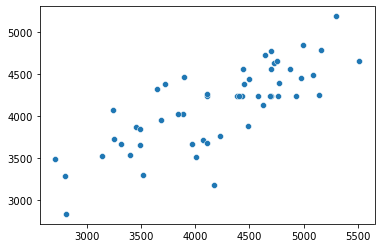

In [96]:
etch_rate_target, uniformity_target, oxide_sel_target, pr_sel_target = y_full.T
etch_rate_actual, uniformity_actual, oxide_sel_actual, pr_sel_actual = final_predictions.T
sns.scatterplot(x=etch_rate_target, y=etch_rate_actual)

<AxesSubplot:>

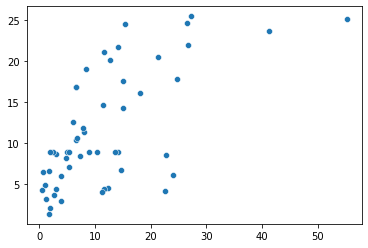

In [100]:
sns.scatterplot(x=uniformity_target, y=uniformity_actual)

<AxesSubplot:>

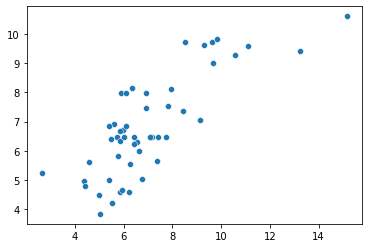

In [98]:
sns.scatterplot(x=oxide_sel_target, y=oxide_sel_actual)

<AxesSubplot:>

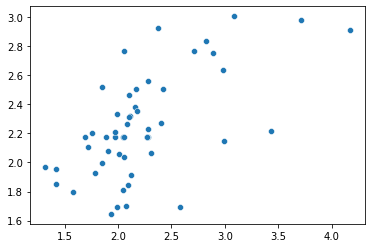

In [99]:
sns.scatterplot(x=pr_sel_target, y=pr_sel_actual)